# Classification with Dirichlet prior

In [3]:
%load_ext autoreload
%autoreload 2
import site
import time
site.addsitedir('..')

import jax
from jax.config import config
import jax.numpy as jnp
import numpy as np
from  matplotlib import pyplot as plt
from tqdm import tqdm

from jax.scipy.special import gammaln
from jax import random

from src.algorithm import *

plt.rcParams["figure.figsize"]=6,6
#config.update("jax_enable_x64", True)

### Setup

The probability vector $\pi$ is drawn from a Dirichlet distribution with parameter $\alpha$.

$\pi \sim \text{Dirichlet}(\alpha)$

The $K$ classes $x_1, \ldots, x_K$ are i.i.d. samples from a standard normal distribution and we have $N$ noisy observations $y_1, \ldots, y_N$ of the $K$ classes such that:

$y_i = x_{z_i} + \sigma \eta_i,$

where $\eta_i \sim \mathcal{N}(0,1)$ and $z_1, \ldots, z_N$ are drawn from a multinomial distribution with
probability vector $\pi$.

In [68]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
key, *subkeys = random.split(key, 5)

In [1]:
K = 10
N = 1000
sigma = 0.01
alpha = jnp.ones(K,)
#alpha = jnp.array([10,10,2])

NameError: name 'jnp' is not defined

In [2]:
pi = random.dirichlet(subkeys[0], alpha)
z = random.categorical(subkeys[1], jnp.log(pi), shape = (N,))
print(f"pi = {pi}")

NameError: name 'random' is not defined

x = [ 0.18469754 -0.22319399  1.3663408 ]


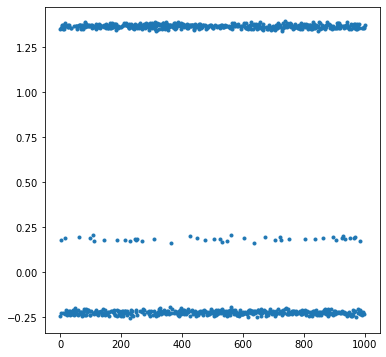

In [71]:
x = random.normal(subkeys[2], shape = (K,))
y = x[z] + sigma * random.normal(subkeys[3], shape = (N,))

print(f"x = {x}")
_ = plt.plot(y, '.')

### The posterior and proposal functions

In [72]:
# This log posterior marginalizes over the classes k = 1,...,K.
def logPi_marg(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) *  (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
              
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) 
   
# And this does not.
def logPi(x, z, y, sigma, alpha):
    n_k = calc_nk_jit(z)
    
    term1 = jnp.sum(-(y - x[z])**2/sigma)

    logPZalpha =  jnp.sum(gammaln(n_k + alpha))

    return term1 - jnp.sum(x**2) + logPZalpha 


def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [73]:
#print(logPi_marg(x, z, y, sigma, alpha))
#print(logPi_marg(xi, zi, y, sigma, alpha))

In [74]:
#print(logPi(x, z, y, sigma, alpha))
#print(logPi(xi, zi, y, sigma, alpha))

In [75]:
@jax.jit
def proposal_x_marg(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_k] from the posterior
    
    p(x_1, ..., x_K | y_1, ..., y_N)
    
    with marginalization over z_1,...z_N."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi_marg(x0, z, y, sigma, alpha)
    logPiX1 = logPi_marg(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function of a new vector [x_1,...,x_K] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    without marginalization over z_i variales (where we keep z_i fixed)."""
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x_idx(key, x0, logPiX0, B, z, y, sigma, alpha, idx):
    """Proposal function for a new state x_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_j are fixed and with no
    marginalization over z.

    The returned vector x1 is equal to x0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.uniform(key) * 2*B-B
    x1 = x0.at[idx].set(newval)
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0    
               
@jax.jit
def proposal_x_batch(key, x0, logPiX0, B, z, y, sigma, alpha):
    """Proposal function for a new state x_j for all j = 1,..., K 
    from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)
    
    where all z_i and the other x_i (i !=j) are fixed and with no
    marginalization over z.
    
    This function returns a new proposal for each x_j i.e.
    it samples x_j "one variable at a time", but for all j 
    in parallel. 

    The returned vector x1 is the same dimensions as x0 and contains
    the proposal states corresponding to each entry. Similarly,
    r, logPiX1 and logPiX0 are arrays of length K, each entry corresponding
    to the proposal x_j with the other x_i fixed, so that this proposal function
    can be used in the "batch" mode of the mcmc function."""
        
    keys = random.split(key, K)
    
    x1, r, logPiX1, logPiX0 = jax.vmap(proposal_x_idx, in_axes = (0, None, None, None, None, None, None, None, 0))(keys, x0, logPiX0, B, z, y, sigma, alpha, jnp.arange(K))
    x1 = jnp.diag(x1)
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Proposal function of a new vector [z_1,...,z_N] from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where the x_i variables are fixed."""
    
    z1 = random.randint(key, z0.shape, 0, K) 

    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_idx(key, z0, logPiX0, x, y, sigma, alpha, K, idx):
    """Proposal function of a new state z_{idx} from the posterior
    
    p(x_1, ..., x_K, z_1, ..., y_N | y_1, ..., y_N)

    where all x_i and the other z_j are fixed.
    
    The returned vector z1 is equal to z0, 
    with the entry at index idx given by the proposal."""
    
    newval = random.randint(key, (), 0, K) 
    z1 = z0.at[idx].set(newval)
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0

@jax.jit
def proposal_z_batch(key, z0, logPiX0, x, y, sigma, alpha, K):
    """Batch mode proposal function for z, operating in the same
    way as proposal_x_batch. 
    
    If the posterior depends on the states z_1,...,z_N (e.g. due to 
    the Dirichlet prior), then running MCMC with this proposal function
    is NOT correct. However, this function is used in the
    proposal_z_batch_correct" function, which takes advantage of these
    parallel proposals in a proper MCMC way."""
    
    keys = random.split(key, N)
    
    # TODO: change both batch functions (this and proposal_x_batch)
    # so we don't have to do diag on an N x N (or K x K) matrix - potentially
    # problematic for large N.
    z1, r, logPiX1, logPiX0 = jax.vmap(proposal_z_idx, in_axes = (0, None, None, None, None, None, None, None, 0))(keys, z0, logPiX0, x, y, sigma, alpha, K, jnp.arange(N))
    z1 = jnp.diag(z1)
    
    return z1, r, logPiX1, logPiX0
    
@jax.jit
def proposal_z_batch_correct(key, z0, logPiX0, x, y, sigma, alpha, K):
    """If using the Dirichlet posterior, then the proposal_z_batch is not 
    proper MCMC sampling. Here, we run a number of "incorect" MCMC steps to 
    sample all the entries of z in parallel, and then use the latest 
    proposed z as a proposal for a "correct" MCMC proposal. The acceptance rate
    is pretty good in this toy example and the convergence great."""
    
    N_samples_z_local = 10   
    keys = random.split(key, 2*N_samples_z_local)
    params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}
    
    logPiZ0 = logPi(x, z0, y, sigma, alpha)
    
    for i in jnp.arange(N_samples_z_local):
        z1, r, logPiX1, logPiX0 = proposal_z_batch(keys[2*i], z0, logPiZ0, **params_z)
        a = jnp.minimum(1, r)
        unif_var = random.uniform(keys[2*i+1], (N,))
        z1, logPiX1 = accept_reject_vmap(unif_var, a, z0, z1, logPiX0, logPiX1)
        
    logPiZ1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiZ1 - logPiZ0)   
    
    return z1, r, logPiZ1, logPiZ0

### Sample x

In [10]:
print(f"pi = {pi}")
print(f"x = {x}")

pi = [0.00829576 0.00063145 0.0532119  0.00551278 0.01030265 0.23252127
 0.1210525  0.28218544 0.05140835 0.23487788]
x = [ 0.18672438 -0.8060988   0.2081677  -1.0280588  -0.09057209 -1.247128
 -1.1854856   1.2729331  -0.6668058   0.04472725]


In [11]:
#z_rand = random.categorical(subkey, jnp.log(pi), shape = (N,))
#z_rand = random.randint(subkey, (N,), 0, K)

#### Sampling the marginalized posterior

  MCMC sample 1000, posterior val = -2566.964111328125, a = 0.0
  MCMC sample 2000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 3000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 4000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 5000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 6000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 7000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 8000, posterior val = -2132.70947265625, a = 0.0
  MCMC sample 9000, posterior val = -2132.70947265625, a = 0.0
27.372939825057983 sec
x_samp = [-0.4849298   2.4636936  -2.0792112  -2.0686455  -0.6531744   1.488595
 -0.6822839  -1.2127833   1.2489777   0.04369068]
x_true = [ 0.18672438 -0.8060988   0.2081677  -1.0280588  -0.09057209 -1.247128
 -1.1854856   1.2729331  -0.6668058   0.04472725]


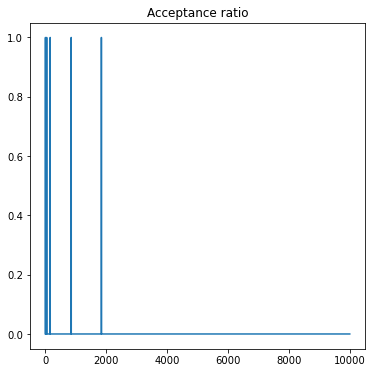

In [12]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

#### And the non-marginalized posterior

  MCMC sample 1000 , posterior val = 4217.203
  MCMC sample 2000 , posterior val = 4214.2246
  MCMC sample 3000 , posterior val = 4215.409
  MCMC sample 4000 , posterior val = 4215.9243
  MCMC sample 5000 , posterior val = 4217.595
  MCMC sample 6000 , posterior val = 4215.233
  MCMC sample 7000 , posterior val = 4212.5396
  MCMC sample 8000 , posterior val = 4217.8413
  MCMC sample 9000 , posterior val = 4219.2866
3.7753212451934814 sec
x_samp = [ 0.18890476  0.5445256   0.19866014 -1.0360394  -0.13163066 -1.2442439
 -1.1854148   1.272008   -0.6727288   0.04340672]
x_true = [ 0.18672438 -0.8060988   0.2081677  -1.0280588  -0.09057209 -1.247128
 -1.1854856   1.2729331  -0.6668058   0.04472725]


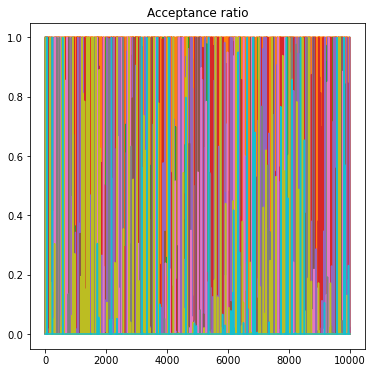

In [13]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, x0, N_samples_x, params_x, K, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

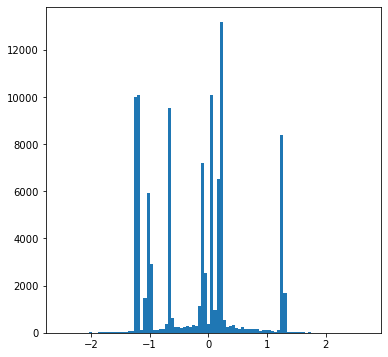

In [14]:
nbins=100
counts, bins = np.histogram(x_samples[:,:], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

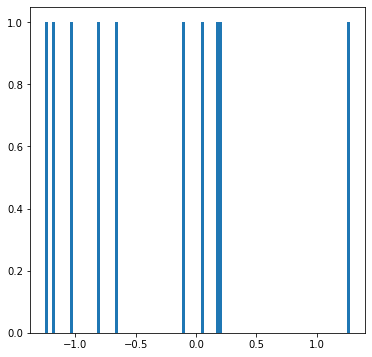

In [15]:
nbins=100
counts, bins = np.histogram(x, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

#### One $x_i$ at a time

  MCMC sample 1000, posterior val = -99031.421875, a = 0.7259221076965332
  MCMC sample 2000, posterior val = -99031.6171875, a = 0.011461634188890457
  MCMC sample 3000, posterior val = -99031.84375, a = 0.6558160185813904
  MCMC sample 4000, posterior val = -99031.9765625, a = 0.5742517113685608
  MCMC sample 5000, posterior val = -99031.578125, a = 0.041924916207790375
  MCMC sample 6000, posterior val = -99031.4609375, a = 1.0
  MCMC sample 7000, posterior val = -99031.5, a = 0.03558121249079704
  MCMC sample 8000, posterior val = -99031.6640625, a = 0.00023419065109919757
  MCMC sample 9000, posterior val = -99031.578125, a = 1.0
  MCMC sample 10000, posterior val = -99031.546875, a = 0.0005887552397325635
3.527191162109375 sec
x_samp = [-0.02695777 -0.35848475  1.0462278   0.5506475   0.20208128  0.6483636
 -0.51367897  0.8306493  -0.19076464 -0.17589898]
x_true = [ 0.18672438 -0.8060988   0.2081677  -1.0280588  -0.09057209 -1.247128
 -1.1854856   1.2729331  -0.6668058   0.044727

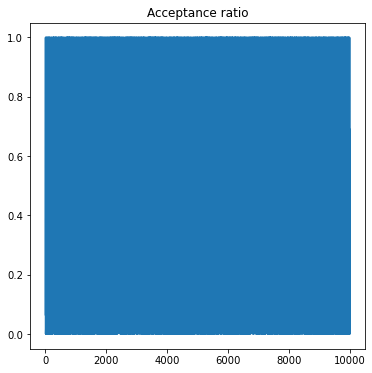

In [16]:
N_samples_x = 10001
B = 3

idx = 1
x0 = jnp.array(np.random.randn(K))

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "idx": idx}

key, subkey = random.split(key)
t0 = time.time()
x_mean, x_r, x_samples = mcmc(subkey, proposal_x_idx, x0, N_samples_x, params_x, 1, 1)

print(f"{time.time()-t0} sec")
plt.plot(x_r); plt.title("Acceptance ratio")
print(f"x_samp = {x_samples[N_samples_x-2]}")
print(f"x_true = {x}")

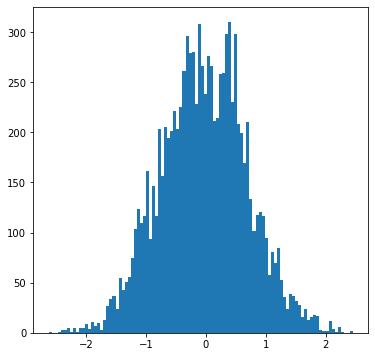

In [17]:
nbins=100
counts, bins = np.histogram(x_samples[:,idx], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

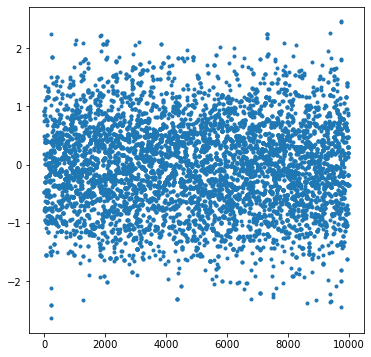

In [18]:
plt.plot(x_samples[:,idx],'.')

### Sample z

In [1]:
N_samples_z = 10000
z0 = jnp.array(np.random.randint(0, K, (N,)))
#z0 = z.at[idx].set(np.random.randint(0,K,()))

B = 2
idx = 10
#params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx}
params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)

t0 = time.time()
#z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, z0, N_samples_z, params_z, 1, 1)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch_correct, z0, N_samples_z, params_z, 1, 1)

z_rec = z_samples[N_samples_z-2]
print(f"{time.time()-t0} sec")
#plt.plot(z_r); plt.title("Acceptance ratio")

NameError: name 'jnp' is not defined

In [20]:
jnp.sum(jnp.abs(z_rec-z))

DeviceArray(228, dtype=int32)

In [21]:
jnp.sum(jnp.abs(z0-z))

DeviceArray(3326, dtype=int32)

In [22]:
print(jnp.sum(jnp.abs(z0-z)))
print(jnp.sum(jnp.abs(z_samples[N_samples_z-2,:]-z)))

3326
228


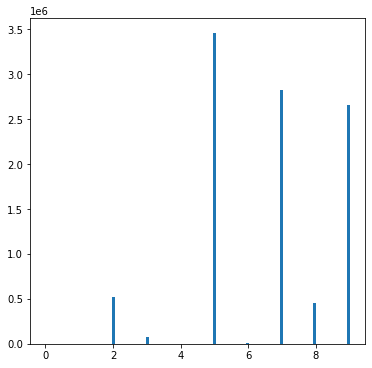

In [23]:
nbins=100
counts, bins = np.histogram(z_samples[:,:], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

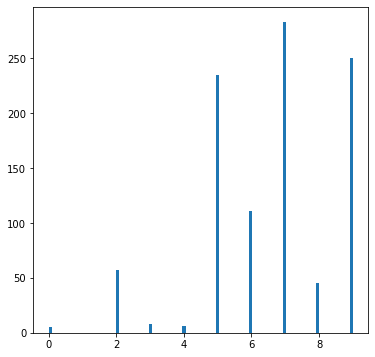

In [24]:
nbins=100
counts, bins = np.histogram(z, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Sample $x$ and $z$

In [76]:
N_iters = 10
N_samples_z = 1001 #300
N_samples_x = 10001
B = 3

sample_x = True
sample_z = True
search_z = False

zi = jnp.array(np.random.randint(0, K, (N,)))
xi = jnp.array(np.random.randn(K))

#xi = x
#zi = z

t0 = time.time()
for iter_i in jnp.arange(N_iters):
    print(f"Iter = {iter_i}")

    if sample_x:
        print("  Sampling x")

        params_x = {"B" : B, "z" : zi, "y" : y, "sigma" : sigma, "alpha" : alpha}

        key, subkey = random.split(key)
    
        #t0 = time.time()
        x_mean, x_r, x_samples = mcmc(subkey, proposal_x_batch, xi, N_samples_x, params_x, K, 1) 
        #x_mean, x_r, x_samples = mcmc(subkey, proposal_x_marg, xi, N_samples_x, params_x, 1, 1) 

        xi = x_samples[N_samples_x - 2]
    
    if search_z:
        print("  Searching z")
        for idx_z in tqdm(jnp.arange(N)):
            logPi_max = -jnp.inf

            for ki in jnp.arange(K):
                zi_k = zi.at[idx_z].set(ki)
                logPi_k = logPi(xi, zi_k, y, sigma, alpha)
                if logPi_k > logPi_max:
                    zi = zi_k
                    logPi_max = logPi_k
            
    if sample_z:
        print("  Sampling z")
        #for idx_z in tqdm(jnp.arange(N)):
            
        #params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K, 'idx' : idx_z}
        params_z = {"x" : xi, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

        key, subkey = random.split(key)

        #z_mean, z_r, z_samples = mcmc(subkey, proposal_z_idx, zi, N_samples_z, params_z, 1, 1)
        #z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch, zi, N_samples_z, params_z, N, 1)
        z_mean, z_r, z_samples = mcmc(subkey, proposal_z_batch_correct, zi, N_samples_z, params_z, 1, 1)

        zi = z_samples[N_samples_z - 2]
            
print(f"{time.time()-t0} sec")
print(f"x_samp = {xi}")
print(f"x_true = {x}")

Iter = 0
  Sampling x
  MCMC sample 1000 , posterior val = -56263.37
  MCMC sample 2000 , posterior val = -56259.21
  MCMC sample 3000 , posterior val = -56260.21
  MCMC sample 4000 , posterior val = -56259.977
  MCMC sample 5000 , posterior val = -56259.367
  MCMC sample 6000 , posterior val = -56259.465
  MCMC sample 7000 , posterior val = -56261.273
  MCMC sample 8000 , posterior val = -56261.043
  MCMC sample 9000 , posterior val = -56261.996
  MCMC sample 10000 , posterior val = -56260.902
  Sampling z
  MCMC sample 1000, posterior val = -52205.703125, a = 0.018315639346837997
Iter = 1
  Sampling x
  MCMC sample 1000 , posterior val = 4548.4814
  MCMC sample 2000 , posterior val = 4549.7812
  MCMC sample 3000 , posterior val = 4549.722
  MCMC sample 4000 , posterior val = 4550.146
  MCMC sample 5000 , posterior val = 4549.327
  MCMC sample 6000 , posterior val = 4549.4414
  MCMC sample 7000 , posterior val = 4550.16
  MCMC sample 8000 , posterior val = 4548.9336
  MCMC sample 9000

504
43
453


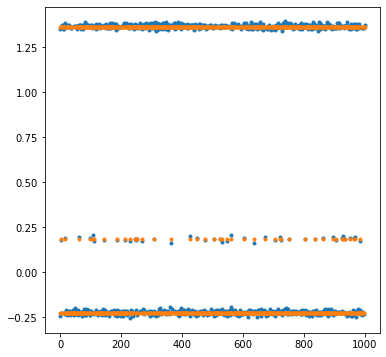

In [77]:
plt.plot(y, '.')
plt.plot(xi[zi], '.')

for k in jnp.arange(K):
    print(jnp.sum(zi==k))

In [78]:
print(logPi(x, z, y, sigma, alpha))
print(logPi(xi, zi, y, sigma, alpha))

5062.181
5061.598


In [79]:
z1 = z.at[0].set(1)
logPiZ0 = logPi(x, z, y, sigma, alpha)
logPiZ1 = logPi(x, z1, y, sigma, alpha)
r = jnp.exp(logPiZ1 - logPiZ0)
r

DeviceArray(0., dtype=float32)

43
453
504


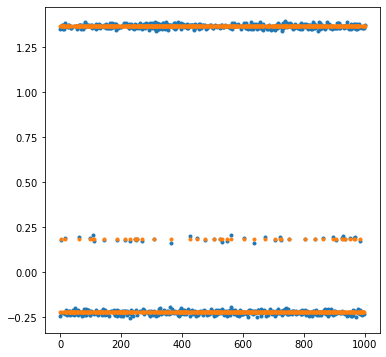

In [80]:
plt.plot(y, '.')
plt.plot(x[z], '.')

for k in jnp.arange(K):
    print(jnp.sum(z==k))

In [81]:
print(pi)
print(x)
print(xi)

[0.04362263 0.42586297 0.5305144 ]
[ 0.18469754 -0.22319399  1.3663408 ]
[ 1.3628206   0.18374133 -0.22451091]


In [61]:
# Loss functions roughly equivalent with the the estimation problem to see what's going on
def loss_fun(x, z, y):
    return (x[z] - y)**2 * pi[z]

def loss_fun_vmap(x,z,y):
    n_k = calc_nk_jit(z)
    logPZalpha = jnp.sum(gammaln(n_k + alpha))
    print(f"logPZalpha = {-logPZalpha}")
    return jnp.sum(jax.vmap(loss_fun, in_axes = (None, 0, 0))(x,z,y)) + jnp.sum(x**2) - logPZalpha

In [62]:
n_k = calc_nk_jit(z)
logPZalpha =  jnp.sum(gammaln(n_k + alpha))

In [63]:
print(loss_fun_vmap(x, jnp.array(np.random.randint(0, K, (N,))), y))
print(loss_fun_vmap(xi, zi, y))
print(loss_fun_vmap(x, z, y))

logPZalpha = -3625.775634765625
-3484.5742
logPZalpha = -4603.2333984375
-4597.9097
logPZalpha = -4226.7861328125
-4218.4053


### Some functions used for debugging - ignore

In [34]:
# Quick test of a proposal function
key, subkey = random.split(key)
idx = 1
z1, rz, _, _ = proposal_z_idx(subkey, z, -1, x, y, sigma, alpha, K, idx)
print(z1[idx])
print(rz)

4
0.0


In [35]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

[[0.005666   0.00069583 0.05735587 ... 0.28200796 0.04542744 0.24821073]
 [0.005666   0.00069583 0.05735587 ... 0.28200796 0.04542744 0.24920477]
 [0.005666   0.00069583 0.05735587 ... 0.28200796 0.04542744 0.24821073]
 ...
 [0.005666   0.00069583 0.05735587 ... 0.28200796 0.04542744 0.24920477]
 [0.005666   0.00069583 0.05735587 ... 0.28200796 0.04542744 0.24821073]
 [0.005666   0.00069583 0.05735587 ... 0.28101394 0.04542744 0.24920477]]


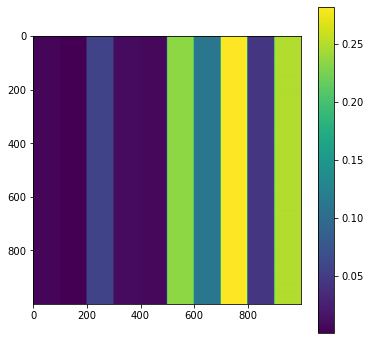

In [36]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   

print(probs_d)
#print(jnp.sum(probs_d, axis=1))

plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [37]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [38]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

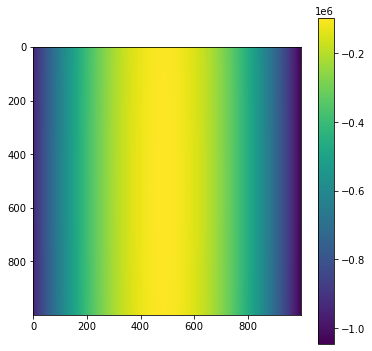

In [39]:
plt.imshow((myf_xy)); plt.colorbar()

In [40]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

01 -148657.67
00 -103394.42
11 -149146.5
10 -103883.27


In [41]:
myf(x[0],x[1])

DeviceArray(-148657.67, dtype=float32)

In [42]:
jnp.max(myf_xy)

DeviceArray(-96284.305, dtype=float32)